### importing the dataset and exploring

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier


In [32]:

df = pd.read_excel("premiums.xlsx")

df.shape

(50000, 13)

In [33]:
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [35]:
df.columns  = df.columns.str.replace("_" , " ").str.lower()

### handling null value

In [36]:
df.isnull().sum()

age                       0
gender                    0
region                    0
marital status            0
number of dependants      0
bmi category              0
smoking status           11
employment status         2
income level             13
income lakhs              0
medical history           0
insurance plan            0
annual premium amount     0
dtype: int64

In [37]:
df.dropna(inplace = True)

In [38]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital status           0
number of dependants     0
bmi category             0
smoking status           0
employment status        0
income level             0
income lakhs             0
medical history          0
insurance plan           0
annual premium amount    0
dtype: int64

### Handling duplicates

In [39]:
df.duplicated().sum()

np.int64(0)

In [40]:
df.drop_duplicates(inplace = True)

In [41]:
df.duplicated().sum()

np.int64(0)

In [42]:
df.describe()

,age,number of dependants,income lakhs,annual premium amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


### cleaning the number of dependants

In [43]:
df[df['number of dependants'] < 0]['number of dependants'].unique()

array([-3, -1])

In [44]:
df['number of dependants']   = df['number of dependants'].abs()

In [45]:
df[df['number of dependants'] < 0]['number of dependants'].nunique()

0

### handling numberical values

In [46]:
numerical_columns  = df.select_dtypes(include  = ["float64" , "int64"]).columns
numerical_columns 

Index(['age', 'number of dependants', 'income lakhs', 'annual premium amount'], dtype='object')

### lets look for outlairs in numerical_columms

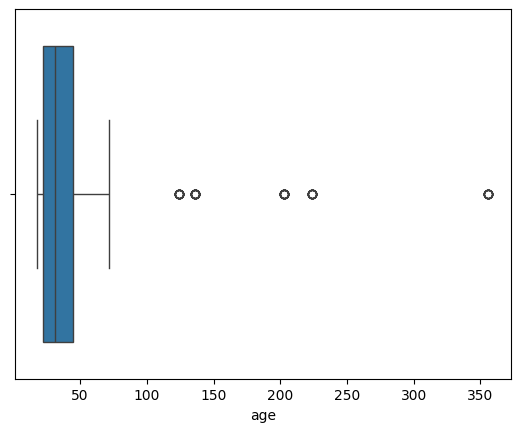

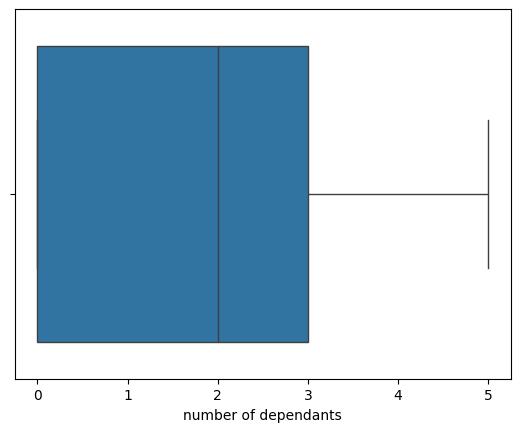

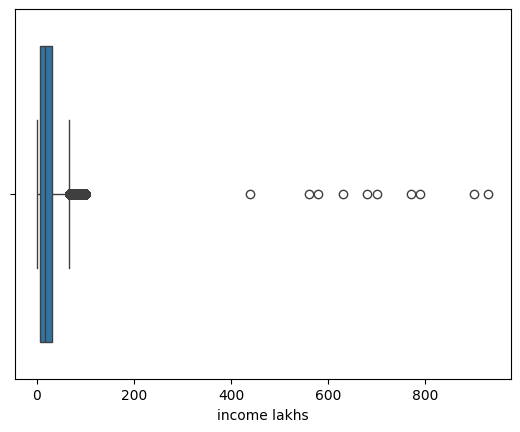

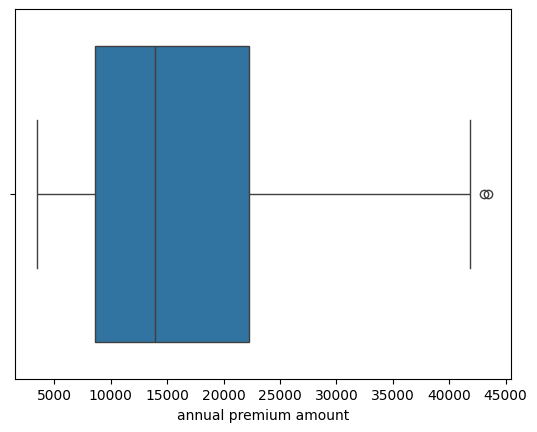

In [47]:
for col in numerical_columns :
    sns.boxplot(x=df[col])
    plt.show()

In [48]:
# yeah age and income have outlairs that need to handle

In [49]:
df[df["age"] > 100]["age"].value_counts().sum()

np.int64(58)

In [50]:
df1  = df[df.age <100]
df1.head()

,age,gender,region,marital status,number of dependants,bmi category,smoking status,employment status,income level,income lakhs,medical history,insurance plan,annual premium amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [51]:
df1.describe()

,age,number of dependants,income lakhs,annual premium amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


In [52]:
# lets handle income

In [53]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower, upper = get_iqr_bounds(df1['income lakhs'])
lower, upper

(-29.0, 67.0)

In [54]:
df1[df["income lakhs"] > upper].shape

C:\Users\Amal\AppData\Local\Temp\ipykernel_23380\3813807125.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1[df["income lakhs"] > upper].shape


(3559, 13)

In [55]:
quantile_thresold = df1["income lakhs"].quantile(0.999)
quantile_thresold

np.float64(100.0)

In [56]:
df1[df1["income lakhs"] > quantile_thresold].shape

(10, 13)

In [57]:
df2  = df1[df1["income lakhs"] <= quantile_thresold].copy()



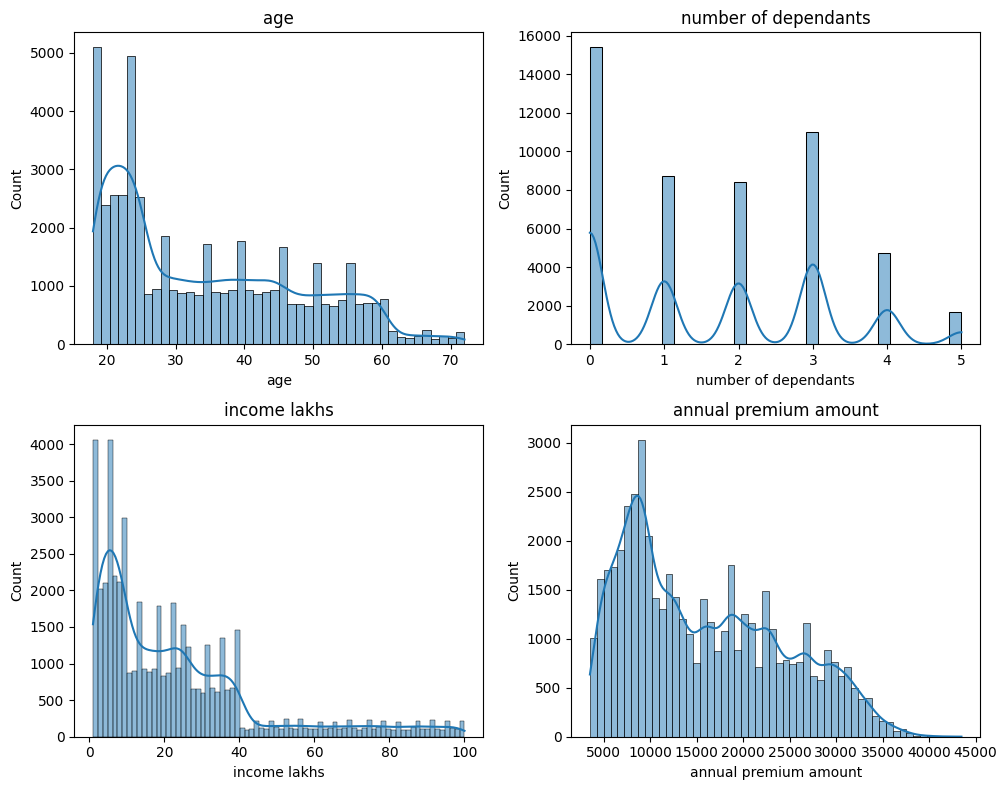

In [58]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Adjust the size as necessary

for i, column in enumerate(numerical_columns):
    ax = axs[i//2, i%2]  # Determines the position of the subplot in the grid
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

In [59]:
categorical_cols = ['gender', 'region', 'marital status', 'bmi category', 'smoking status', 'employment status', 'income level', 'medical history', 'insurance plan']
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital status : ['Unmarried' 'Married']
bmi category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment status : ['Salaried' 'Self-Employed' 'Freelancer']
income level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance plan : ['Bronze' 'Silver' 'Gold']


In [62]:
map_smoking_value = {
    "No Smoking" : "No Smoking" ,
    'Smoking=0' : "No Smoking",
    'Does Not Smoke': "No Smoking",
     'Not Smoking':"No Smoking",}

df2["smoking status"].replace(map_smoking_value , inplace = True)

df2["smoking status"].nunique()


3

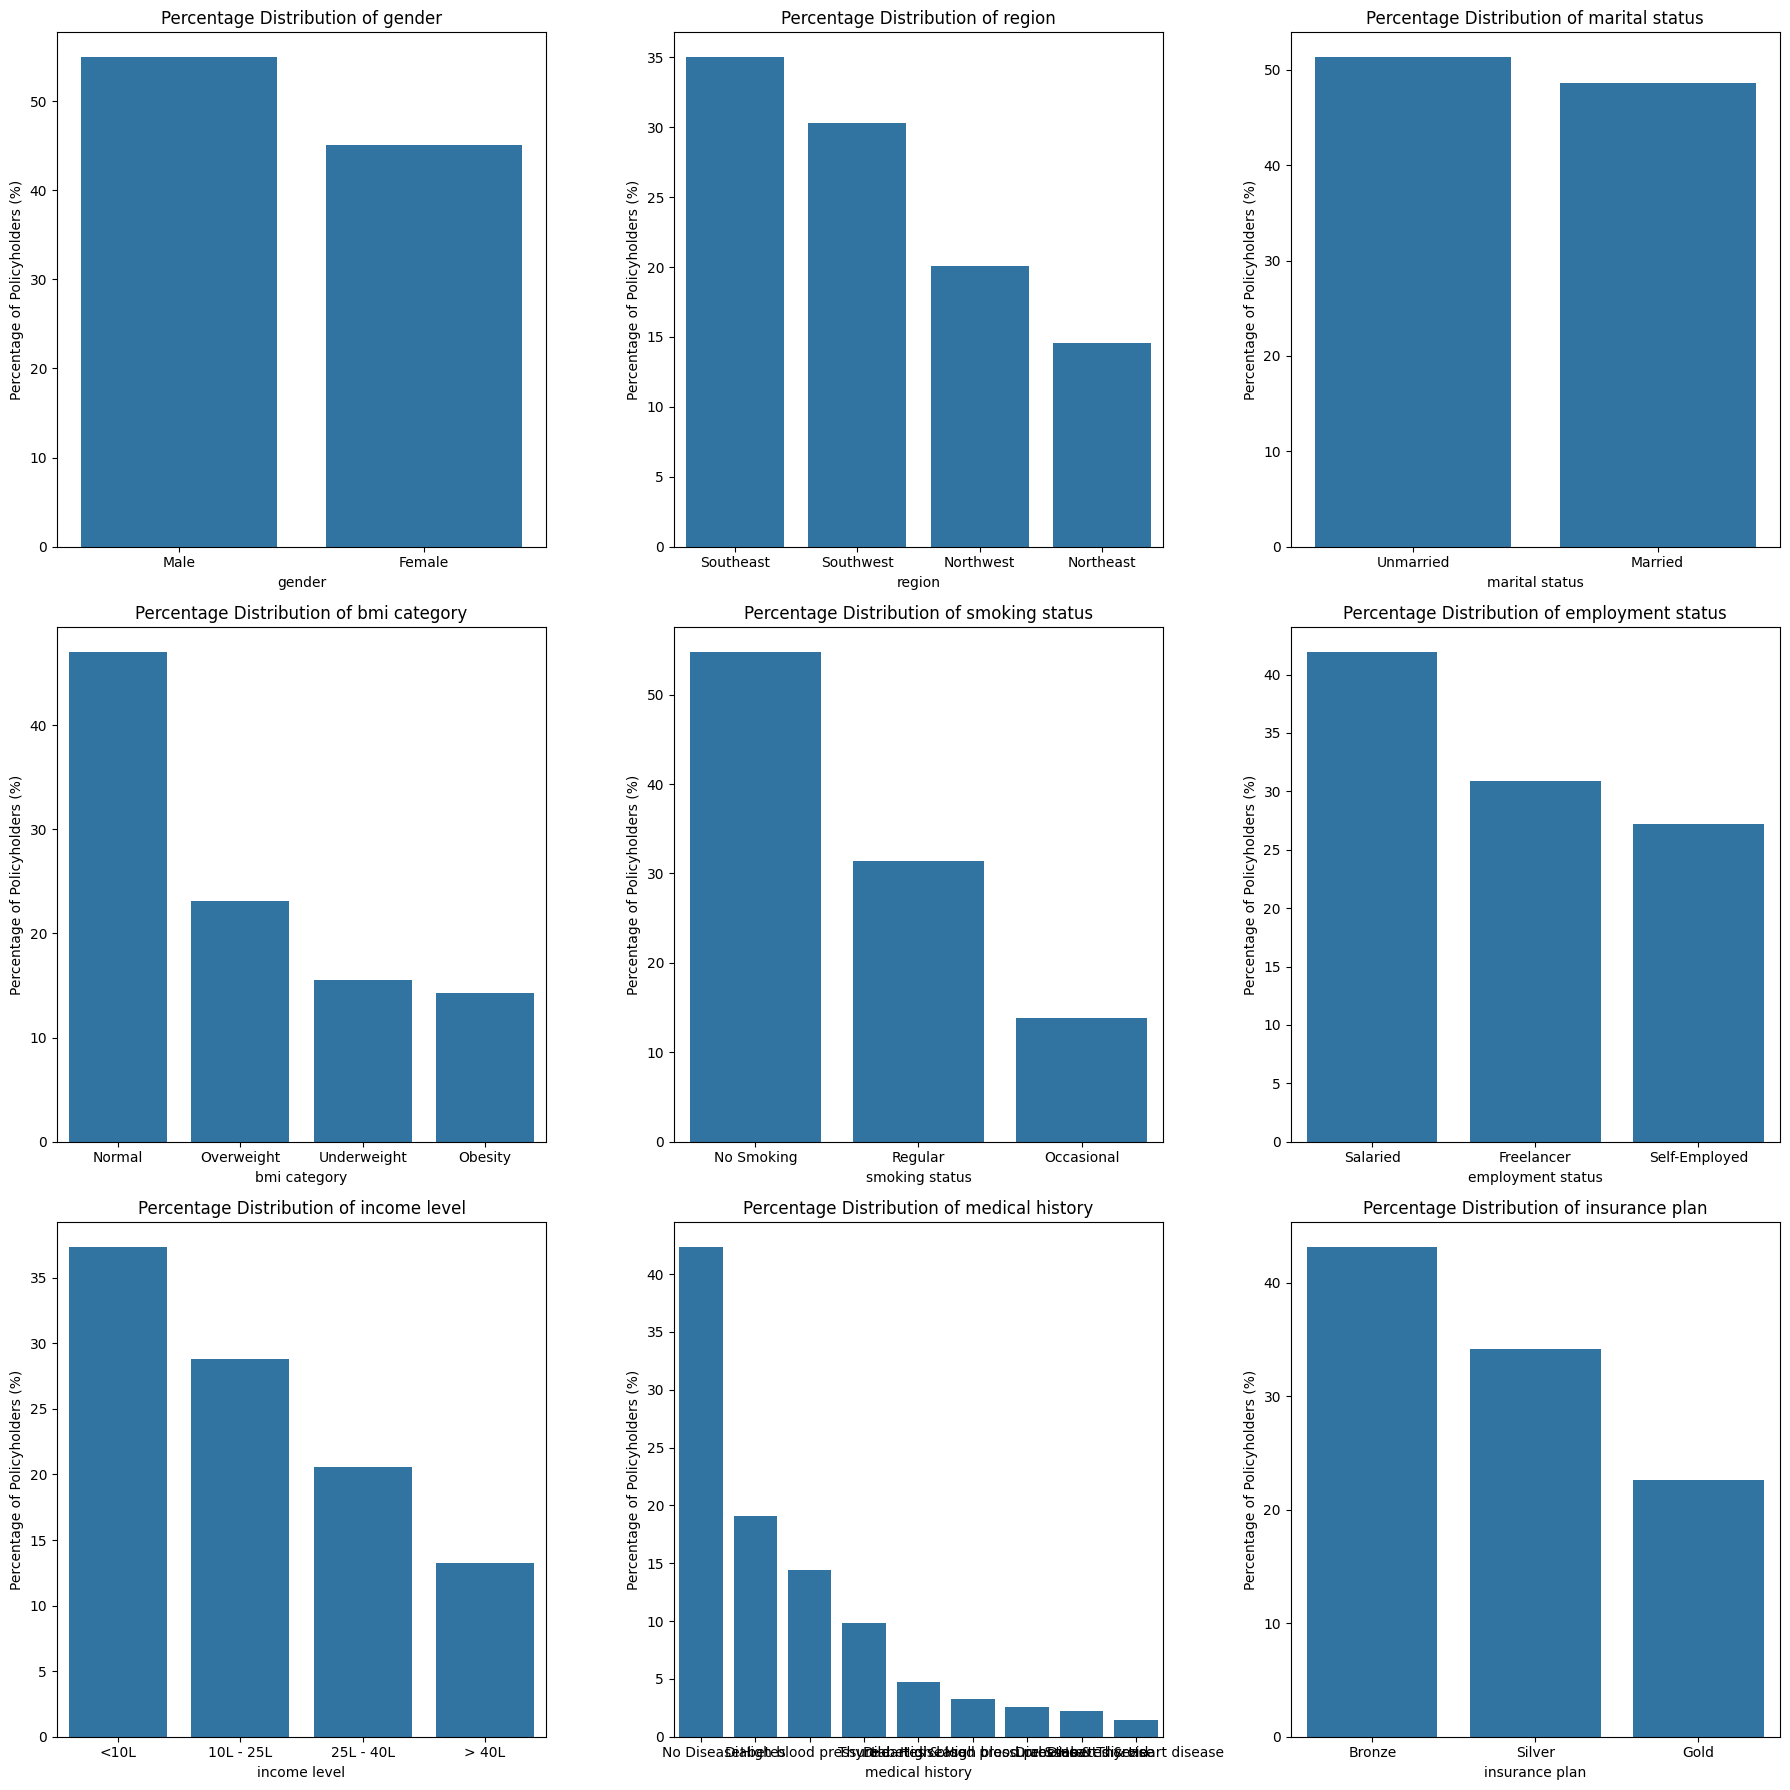

In [63]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

### Bivariate Analysis

insurance plan  Bronze  Gold  Silver
income level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


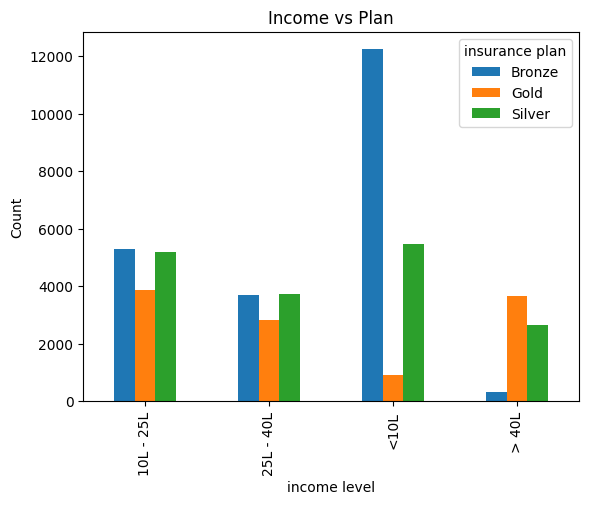

In [68]:
# Cross-tabulation of gender and smoking status
crosstab = pd.crosstab(df2['income level'], df2['insurance plan'])
print(crosstab)

# Plotting the crosstab
crosstab.plot(kind='bar')
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

### Feature Engineering

In [69]:
df2.head()

,age,gender,region,marital status,number of dependants,bmi category,smoking status,employment status,income level,income lakhs,medical history,insurance plan,annual premium amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [71]:
df2["medical history"].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [78]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

C:\Users\Amal\AppData\Local\Temp\ipykernel_23380\949550731.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
C:\Users\Amal\AppData\Local\Temp\ipykernel_23380\949550731.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

,age,gender,region,marital status,number of dependants,bmi category,smoking status,employment status,income level,income lakhs,medical history,insurance plan,annual premium amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571


### Encode Text Columns

In [79]:
df2['insurance plan'] = df2['insurance plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})